# Stack Overflow Developer Survey Analysis

## Importing Necessary Libraries

In [49]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency


## Data Extraction and Loading

In [56]:
# Paths for the datasets
zip_path_2023 = "stack-overflow-developer-survey-2023.zip"
extracted_path_2023 = "stack-overflow-developer-survey-2023"

# Extracting the 2023 zip file and loading the dataset
with zipfile.ZipFile(zip_path_2023, 'r') as zip_ref:
    zip_ref.extractall(extracted_path_2023)

survey_results_2023 = pd.read_csv(os.path.join(extracted_path_2023, "survey_results_public.csv"))
survey_questions_2023 = pd.read_csv(os.path.join(extracted_path_2023, "survey_results_schema.csv"))

In [43]:
job_columns = survey_results_2023.columns[survey_results_2023.columns.str.contains('Job', case=False)]
print(job_columns)

Index([], dtype='object')


In [46]:
print(job_columns)

column_names = survey_results_2023.columns.tolist()
pd.set_option('display.max_columns', None)
print(column_names)



Index([], dtype='object')
['ResponseId', 'Q120', 'MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool', 'Country', 'Currency', 'CompTotal', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith', 'PlatformWantToWorkWith', 'WebframeHaveWorkedWith', 'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use', 'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith', 'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith', 'AISearchWantToWorkWith', 'AIDevHaveWorkedWith', 'AIDevWantToWorkWith', 'NEWSOSites', 'SOVisitFre

## Programming Popularity

* Which programming languages, frameworks, and tools are the most popular?
* Are there significant differences in the popularity of these technologies across different age groups or regions?


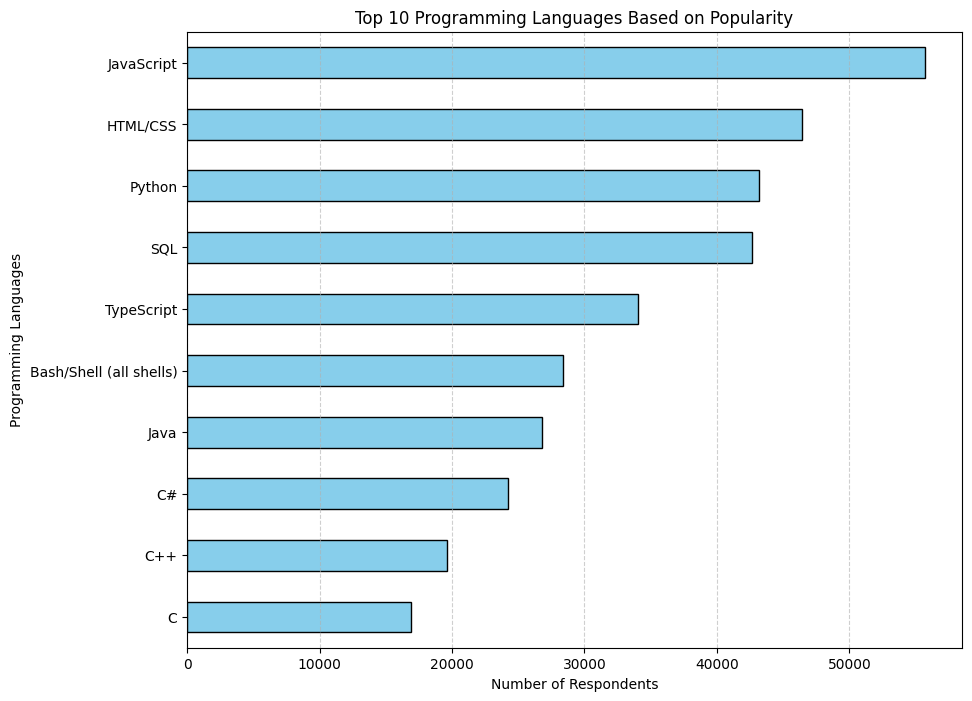

In [7]:
# Visualize top 10 programming languages
languages = survey_results_2023['LanguageHaveWorkedWith'].str.split(';', expand=True).stack()
language_counts = languages.value_counts()
plt.figure(figsize=(10,8))
language_counts.head(10).sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Programming Languages Based on Popularity')
plt.xlabel('Number of Respondents')
plt.ylabel('Programming Languages')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

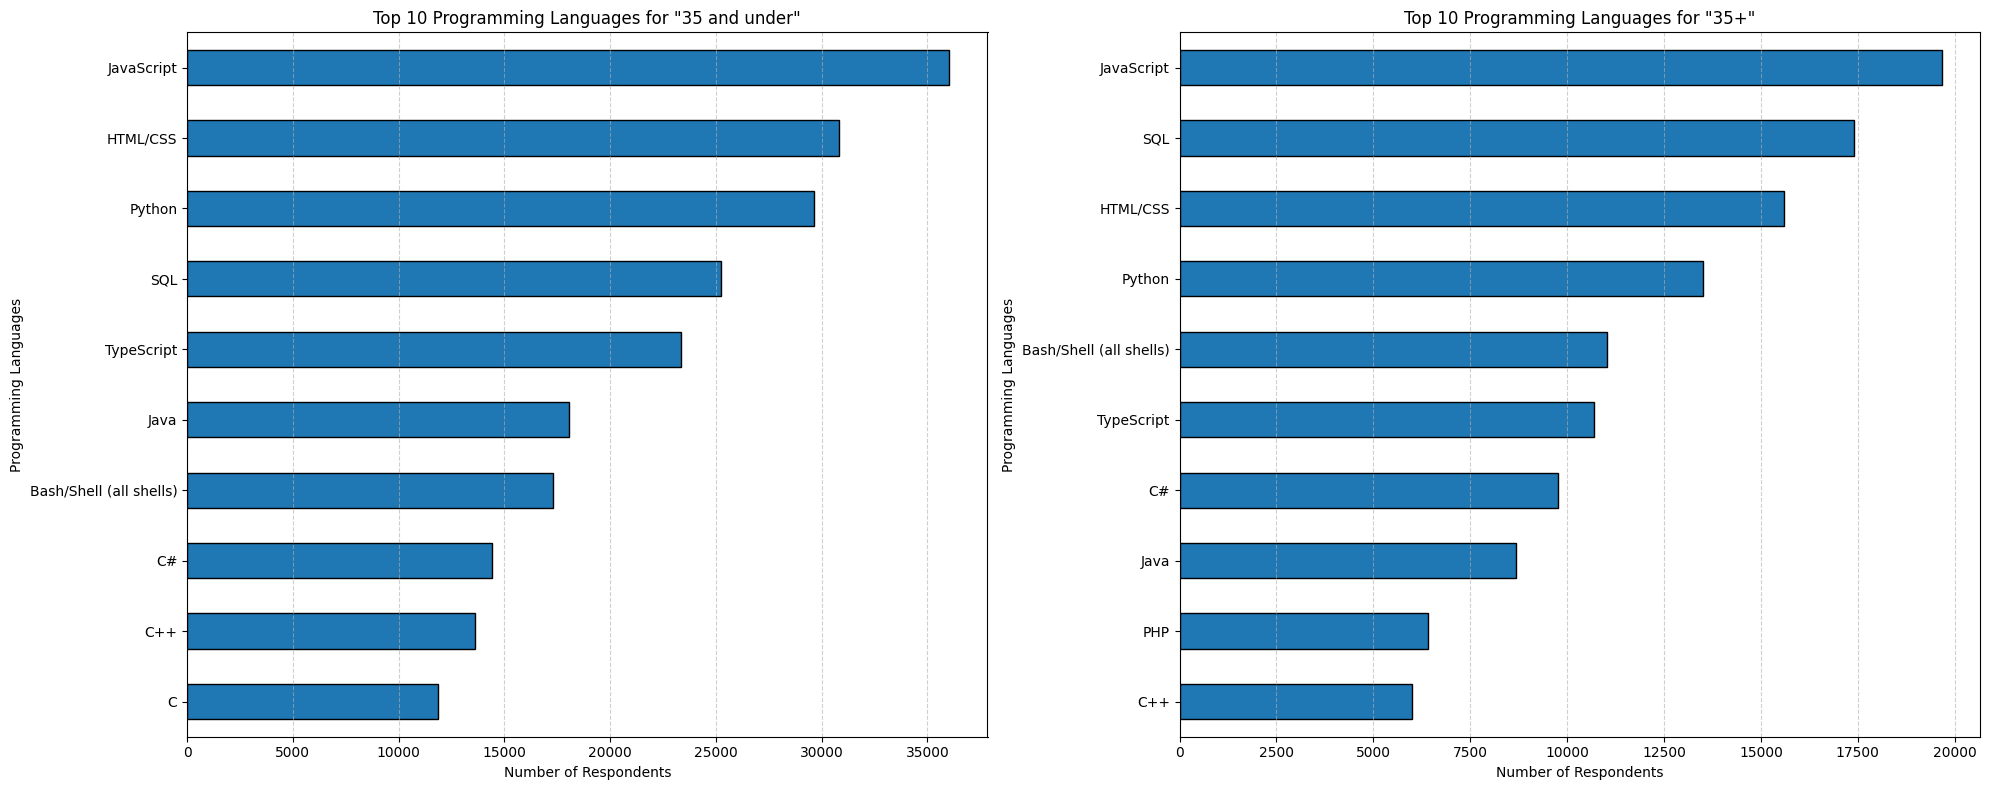

In [20]:
# Bucketing by Age
# Create age group buckets
survey_results_2023['AgeBucket'] = np.where(survey_results_2023['Age'].isin(['Under 18 years old', '18-24 years old', '25-34 years old']), 
                                           '35 and under', '35+')
# Segment data by age buckets and calculate programming language popularity
languages_by_bucket = {}
buckets = ['35 and under', '35+']
for bucket in buckets:
    bucket_data = survey_results_2023[survey_results_2023['AgeBucket'] == bucket]
    languages = bucket_data['LanguageHaveWorkedWith'].str.split(';', expand=True).stack()
    languages_by_bucket[bucket] = languages.value_counts()

# print(languages_by_bucket)

# Visualize programming language popularity for each bucket
plt.figure(figsize=(20, 8))
for idx, bucket in enumerate(buckets,1):
    plt.subplot(1, 2, idx)
    language_counts = languages_by_bucket[bucket].head(10).sort_values()
    # colors = sns.color_palette('Set3', len(language_counts))
    language_counts.plot(kind='barh', edgecolor='black')
    plt.title(f'Top 10 Programming Languages for "{bucket}"')
    plt.xlabel('Number of Respondents')
    plt.ylabel('Programming Languages')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
# 3. Statistical Testing
# Prepare observed frequencies for Chi-Squared test
top_languages = set()
for counts in languages_by_bucket.values():
    top_languages.update(counts.index)
top_languages = list(top_languages)

observed_frequencies_bucket = []
for bucket in buckets:
    row = [languages_by_bucket[bucket].get(language, 0) for language in top_languages]
    observed_frequencies_bucket.append(row)

# print(observed_frequencies_bucket)

# Perform the Chi-Squared test
chi2_bucket, p_value, _, _ = chi2_contingency(observed_frequencies_bucket)

# Calculate Cramér's V
n = survey_results_2023['AgeBucket'].count()
k = len(top_languages)
cramers_v = np.sqrt(chi2_bucket / (n * min(k-1, 2-1)))

print(f'Chi-Squared Statistic: {chi2_bucket}')
print(f'p-value: {p_value}')
print(f'Cramér\'s V: {cramers_v}')

Chi-Squared Statistic: 11062.898432958003
p-value: 0.0
Cramér's V: 0.35220132793114406


## Predicting Developer Role:

Objective:
The goal of the model is to predict a developer's job role based on certain features from the survey data.

Features:
Programming Languages (LanguageHaveWorkedWith): The programming languages that a respondent has worked with. Each programming language (e.g., Python, JavaScript) is represented as a separate binary column, indicating whether the respondent has worked with that language.

Platforms (PlatformHaveWorkedWith): The platforms or operating systems that a respondent has worked with. Each platform (e.g., Linux, Windows) is represented as a separate binary column, indicating whether the respondent has worked with that platform.

Databases (DatabaseHaveWorkedWith): The databases that a respondent has worked with. Each database (e.g., MySQL, PostgreSQL) is represented as a separate binary column, indicating whether the respondent has worked with that database.

Web Frameworks (WebframeHaveWorkedWith): The web frameworks that a respondent has worked with. Each framework (e.g., React.js, Flask) is represented as a separate binary column, indicating whether the respondent has worked with that framework.

Years of Professional Coding Experience (YearsCodePro): The number of years a respondent has been coding professionally. This provides an indication of their experience level.

Education Level (EdLevel): The highest level of formal education the respondent has completed, such as "Bachelor's degree", "Master's degree", etc. Each education level is represented as a separate binary column.

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


# Filtering and preparing the data
filtered_data = survey_results_2023.dropna(subset=['DevType'])

# Filter necessary columns
features = ['LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 'DatabaseHaveWorkedWith', 
            'WebframeHaveWorkedWith', 'YearsCodePro', 'EdLevel', 'DevType']
filtered_data = filtered_data[features]

# Transforming YearsCodePro to numerical format for ease of imputation later
filtered_data['YearsCodePro'] = filtered_data['YearsCodePro'].replace({'Less than 1 year': 0.5, 'More than 50 years': 51}).astype(float)

# Splitting the data into training and testing sets
X = filtered_data.drop('DevType', axis=1)
y = filtered_data['DevType']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values AFTER splitting
imputer = SimpleImputer(strategy='most_frequent')

# Fit on training data and transform both training and test data
X_train['YearsCodePro'] = imputer.fit_transform(X_train[['YearsCodePro']])
X_test['YearsCodePro'] = imputer.transform(X_test[['YearsCodePro']])
# X_train['EdLevel'] = imputer.fit_transform(X_train[['EdLevel']])
# X_test['EdLevel'] = imputer.transform(X_test[['EdLevel']])

# One-hot encoding for categorical columns
languages_train = X_train['LanguageHaveWorkedWith'].str.get_dummies(sep=';')
languages_test = X_test['LanguageHaveWorkedWith'].str.get_dummies(sep=';')
platforms_train = X_train['PlatformHaveWorkedWith'].str.get_dummies(sep=';')
platforms_test = X_test['PlatformHaveWorkedWith'].str.get_dummies(sep=';')
databases_train = X_train['DatabaseHaveWorkedWith'].str.get_dummies(sep=';')
databases_test = X_test['DatabaseHaveWorkedWith'].str.get_dummies(sep=';')
webframes_train = X_train['WebframeHaveWorkedWith'].str.get_dummies(sep=';')
webframes_test = X_test['WebframeHaveWorkedWith'].str.get_dummies(sep=';')
education_train = pd.get_dummies(X_train['EdLevel'], prefix='Edu')
education_test = pd.get_dummies(X_test['EdLevel'], prefix='Edu')

# Concatenate all features
X_train = pd.concat([X_train['YearsCodePro'], languages_train, platforms_train, databases_train, webframes_train, education_train], axis=1)
X_test = pd.concat([X_test['YearsCodePro'], languages_test, platforms_test, databases_test, webframes_test, education_test], axis=1)

# Scale the numeric feature
scaler = StandardScaler()
X_train['YearsCodePro'] = scaler.fit_transform(X_train[['YearsCodePro']])
X_test['YearsCodePro'] = scaler.transform(X_test[['YearsCodePro']])

# Initialize and train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions (not executed, just for reference)
y_pred = clf.predict(X_test)

# Evaluating the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=y_test.unique())

# Print accuracy
print(f'Accuracy: {accuracy}')

# Print classification report
print('Classification Report:')
print(classification_rep)

Accuracy: 0.4606829268292683
Classification Report:
                                               precision    recall  f1-score   support

                        Developer, full-stack       0.32      0.30      0.31       260
                  Research & Development role       0.20      0.03      0.05        66
                          Developer, back-end       0.32      0.04      0.07       215
                                      Student       0.31      0.15      0.20       178
                  Developer, game or graphics       0.29      0.25      0.27       304
                               Engineer, data       0.38      0.07      0.11        45
Data scientist or machine learning specialist       0.00      0.00      0.00        57
Developer, desktop or enterprise applications       0.20      0.03      0.05       283
                         Developer, front-end       0.00      0.00      0.00        33
                        Developer, QA or test       0.00      0.00      0.00 

                     Feature  Importance
0               YearsCodePro    0.086929
25                JavaScript    0.019969
22                  HTML/CSS    0.019722
5    Bash/Shell (all shells)    0.019099
48                TypeScript    0.018661
..                       ...         ...
100                  RavenDB    0.000441
17                      Flow    0.000422
40                      Raku    0.000360
1                        APL    0.000324
106                     TiDB    0.000316

[149 rows x 2 columns]


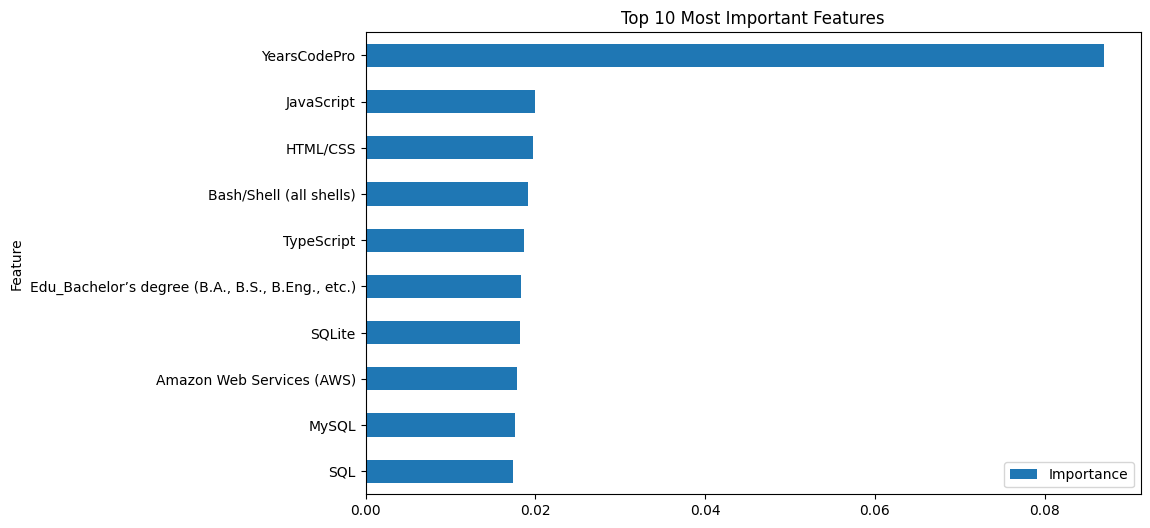

In [61]:

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
sorted_features = features_df.sort_values(by='Importance', ascending=False)

# Print the sorted features
print(sorted_features)

# Plotting top N features
N = 10  # or any other number you prefer
sorted_features.head(N).plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6))
plt.title('Top {} Most Important Features'.format(N))
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


## Salary differences across Developer Roles 

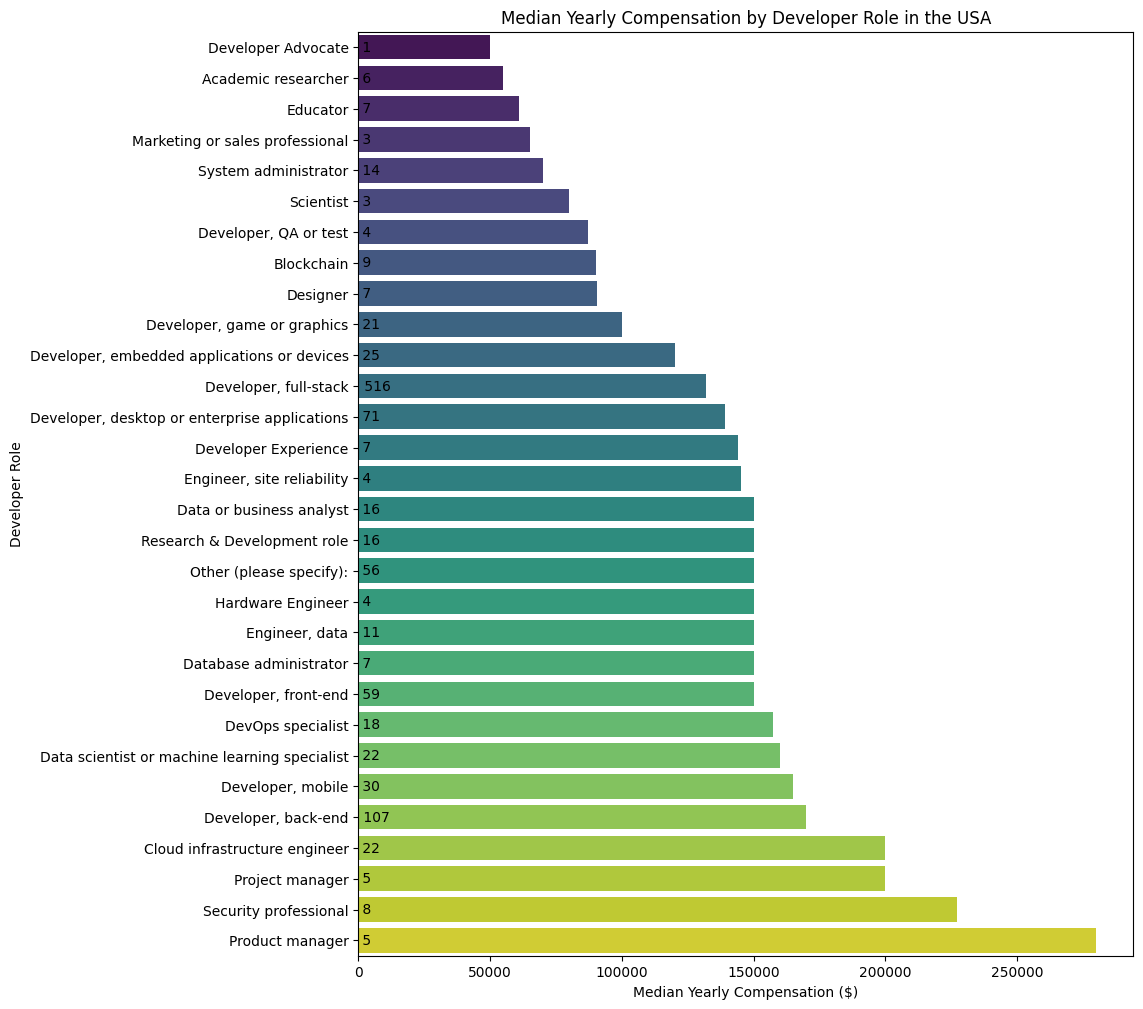

In [107]:
# Filter data for respondents in the USA

mask = ((survey_results_2023['Country'] == 'United States of America') 
        &(survey_results_2023['Employment'].str.contains('Employed, full time|Independent contractor, freelancer, or self-employed', na=False, regex=True))
       & (~survey_results_2023['DevType'].str.contains('Senior Executive|Student|Engineering manager', na=False, regex=True))
       & survey_results_2023['ConvertedCompYearly'].notnull()
        )


usa_full_time_ic = survey_results_2023[mask]

# Calculate median salary for each developer role
median_salaries = usa_full_time_ic.groupby('DevType')['ConvertedCompYearly'].median().sort_values()
# Calculate count of entries for each DevType
count_entries = usa_full_time_ic['DevType'].value_counts().sort_values()
# Sort count_entries based on the order of developer roles in median_salaries
count_entries = count_entries.reindex(median_salaries.index)

# Plotting the results
plt.figure(figsize=(10, 12))
sns.barplot(y=median_salaries.index, x=median_salaries.values, palette="viridis")
plt.xlabel('Median Yearly Compensation ($)')
plt.ylabel('Developer Role')
plt.title('Median Yearly Compensation by Developer Role in the USA')

# Add count of entries on top of each horizontal column
for i, count in enumerate(count_entries):
    plt.text(count, i, f' {count}', va='center')

plt.show()

In [112]:
usa_full_time_ic[['ConvertedCompYearly','DevType']].head()
groups =(usa_full_time_ic['ConvertedCompYearly'][usa_full_time_ic['DevType'] == dev_type] for dev_type in usa_full_time_ic['DevType'].unique())
print(groups)

<generator object <genexpr> at 0x13f907300>


In [122]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Handle missing values: Remove rows where either 'DevType' or 'ConvertedCompYearly' is missing
usa_no_null = usa_full_time_ic.loc[:,['DevType', 'ConvertedCompYearly']].dropna(subset=['DevType', 'ConvertedCompYearly'])

groups =(usa_no_null['ConvertedCompYearly'][usa_no_null['DevType'] == dev_type] for dev_type in usa_no_null['DevType'].unique())

# 1. ANOVA Test
f_value, p_value = stats.f_oneway(*groups)

# Print the results
print(f"F-Value: {f_value}")
print(f"P-Value: {p_value}")

# 2. Post-hoc Analysis (if p_value < 0.05)
if p_value < 0.05:
    tukey_results = pairwise_tukeyhsd(endog=usa_no_null['ConvertedCompYearly'], groups=usa_no_null['DevType'], alpha=0.1)
    print(tukey_results.summary())



F-Value: 3.0217641811703224
P-Value: 1.9266807043446141e-07
                                              Multiple Comparison of Means - Tukey HSD, FWER=0.10                                              
                    group1                                        group2                      meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------------------------------------------------------------------------------------
                          Academic researcher                                    Blockchain   20722.2222    1.0 -193123.9253 234568.3697  False
                          Academic researcher                 Cloud infrastructure engineer  142878.7879 0.6222  -43993.4262  329751.002  False
                          Academic researcher                      Data or business analyst   85253.8333 0.9996 -108981.5759 279489.2426  False
                          Academic researcher Data scientist or machine lear